# Forecasting Book Sales with RNN

## Import modules and loading the dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
import logging
tf.get_logger().setLevel(logging.ERROR)
import pandas as pd

EPOCHS=100
BATCH_SIZE=16
TRAIN_TEST_SPLIT=0.8
MIN=12
FILE_NAME='../Forecasting Book Sales/book_stores_sales.csv'

def readfile(file_name):
    file = open(file_name, 'r', encoding='utf-8')
    next(file)
    data = []
    for line in (file):
        values = line.split(',')
        data.append(float(values[1]))
    file.close()
    return np.array(data, dtype=np.float32)

##  Read  the data and split into training and test data

In [11]:
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

## Plot Dataset

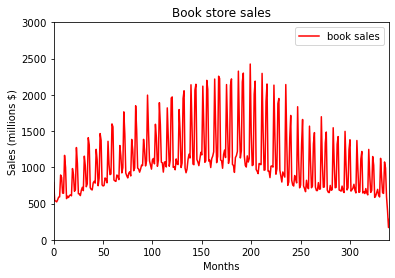

In [12]:
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()

## Standardize train and test data
### By subtracting the mean and dividing by the standard deviation

In [13]:
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev

## Create training and test examples

In [14]:
# Training Example
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1))
train_y = np.zeros((train_months-MIN, 1))
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
    train_y[i, 0] = train_sales_std[i+MIN]

# Test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1))
test_y = np.zeros((test_months-MIN, 1))
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
    test_y[i, 0] = test_sales_std[i+MIN]

## Create the RNN model

In [15]:
model = Sequential()
model.add(SimpleRNN(128, activation='relu',
                    input_shape=(None, 1)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam',
              metrics =['mean_absolute_error'])
model.summary()
history = model.fit(train_X, train_y,
                    validation_data
                    = (test_X, test_y), epochs=EPOCHS,
                    batch_size=BATCH_SIZE, verbose=2,
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 - 1s - loss: 0.8109 - mean_absolute_error: 0.6492 - val_loss: 0.5405 - val_mean_absolute_error: 0.6639 - 1s/epoch - 84ms/step
Epoch 2/100
17/17 - 1s - loss: 0.4648 - mean_absolute_error: 0.5151 - val_loss: 0.2408 - val_mean_absolute_error: 0.3681 - 578ms/epoch - 34ms/step
Epoch 3/100
17/17 - 1s - loss: 0.2968 - mean_absolute_error: 0.3991 - val_loss: 0.1567 - val_mean_absolute_error: 0.2773 - 565ms/epoch - 33ms/step
Epoch 4/10

Epoch 52/100
17/17 - 1s - loss: 0.0144 - mean_absolute_error: 0.0873 - val_loss: 0.0590 - val_mean_absolute_error: 0.1696 - 600ms/epoch - 35ms/step
Epoch 53/100
17/17 - 1s - loss: 0.0149 - mean_absolute_error: 0.0867 - val_loss: 0.0695 - val_mean_absolute_error: 0.1792 - 580ms/epoch - 34ms/step
Epoch 54/100
17/17 - 1s - loss: 0.0168 - mean_absolute_error: 0.0907 - val_loss: 0.0464 - val_mean_absolute_error: 0.1500 - 575ms/epoch - 34ms/step
Epoch 55/100
17/17 - 1s - loss: 0.0176 - mean_absolute_error: 0.0982 - val_loss: 0.0349 - val_mean_absolute_error: 0.1299 - 590ms/epoch - 35ms/step
Epoch 56/100
17/17 - 1s - loss: 0.0137 - mean_absolute_error: 0.0895 - val_loss: 0.0533 - val_mean_absolute_error: 0.1684 - 592ms/epoch - 35ms/step
Epoch 57/100
17/17 - 1s - loss: 0.0131 - mean_absolute_error: 0.0882 - val_loss: 0.0346 - val_mean_absolute_error: 0.1202 - 572ms/epoch - 34ms/step
Epoch 58/100
17/17 - 1s - loss: 0.0131 - mean_absolute_error: 0.0845 - val_loss: 0.0366 - val_mean_absolute_erro

## Create naive prediction based on standardized data

In [17]:
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)

naive test mse:  0.4888956
naive test mean abs:  0.49055263


In [18]:
# The RNN model does a significantly better job than the naive model

In [19]:
predicted_test = model.predict(test_X, len(test_X))
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

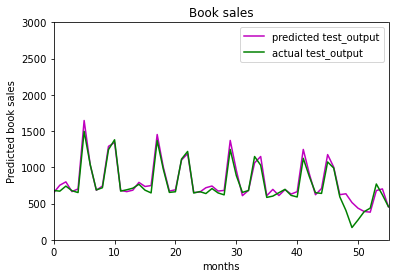

In [20]:
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-',
         label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
         'g-', label='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()